# Fukuro GMRT UGM - Adaptive Monte Carlo Localization (AMCL)
by Marco Aland Adinanda

This notebook explains a 2D AMCL alogrithm for Fukuro (wheeled soccer robot) localizaiton using particle filters. 

## 1. Import Required Libraries

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.animation import FuncAnimation

## 2. Particle Class

In [2]:
class Particle:
    def __init__(self, x, y, weight):
        self.x = x
        self.y = y
        self.weight = weight

- Kelas Particle merepresentasikan partikel dengan posisi (x, y) dan bobot (weight).
- Bobot menunjukkan probabilitas partikel tersebut sebagai lokasi robot yang benar.
- Tidak ada orientasi (theta) dalam implementasi ini, sehingga hanya bekerja dalam ruang 2D.

## 3. AMCL

In [3]:
class AMCL:
    def __init__(self, num_particles, map_landmarks, initial_pose=None):
        self.num_particles = num_particles
        self.map_landmarks = map_landmarks
        self.particles = []
        
        if initial_pose:
            x, y = initial_pose
            for _ in range(num_particles):
                noise_x = np.random.normal(x, 1)
                noise_y = np.random.normal(y, 1)
                self.particles.append(Particle(noise_x, noise_y, 1.0/num_particles))

    def predict(self, u, noise):
        std_x, std_y = noise
        for p in self.particles:
            p.x += u[0] + np.random.normal(0, std_x)
            p.y += u[1] + np.random.normal(0, std_y)

    def update(self, measurements, range_std, bearing_std):
        for p in self.particles:
            p.weight = 1.0
            for (landmark_id, measured_range, measured_bearing) in measurements:
                lx, ly = self.map_landmarks[landmark_id]
                dx = lx - p.x
                dy = ly - p.y
                expected_range = np.hypot(dx, dy)
                expected_bearing = np.arctan2(dy, dx)
                expected_bearing = (expected_bearing + np.pi) % (2 * np.pi) - np.pi
                
                # Hitung likelihood
                prob_range = (1.0 / (range_std * np.sqrt(2 * np.pi))) * \
                           np.exp(-0.5 * ((measured_range - expected_range)/range_std)**2)
                prob_bearing = (1.0 / (bearing_std * np.sqrt(2 * np.pi))) * \
                             np.exp(-0.5 * ((measured_bearing - expected_bearing)/bearing_std)**2)
                p.weight *= prob_range * prob_bearing
        
        total_weight = sum(p.weight for p in self.particles)
        if total_weight == 0:
            for p in self.particles:
                p.weight = 1.0 / self.num_particles
        else:
            for p in self.particles:
                p.weight /= total_weight

    def resample(self):
        weights = [p.weight for p in self.particles]
        cumulative_weights = np.cumsum(weights)
        step = cumulative_weights[-1] / self.num_particles
        start = np.random.uniform(0, step)
        
        indexes = []
        for i in range(self.num_particles):
            pointer = start + i * step
            index = np.searchsorted(cumulative_weights, pointer)
            indexes.append(index % len(self.particles))
        
        new_particles = [Particle(self.particles[i].x, self.particles[i].y, 1.0/self.num_particles)
                        for i in indexes]
        self.particles = new_particles

    def get_estimated_pose(self):
        x = sum(p.x * p.weight for p in self.particles)
        y = sum(p.y * p.weight for p in self.particles)
        return (x, y)

a. Inisialisasi Partikel:
- Partikel diinisialisasi di sekitar posisi awal (initial_pose) dengan noise normal (mean=0, std=1).
- Bobot awal setiap partikel adalah 1/num_particles untuk memastikan jumlah total bobot adalah 1

b. Langkah Prediksi:
- Memperbarui posisi partikel berdasarkan input kontrol u = (dx, dy).
- Noise Gaussian ditambahkan ke setiap partikel:

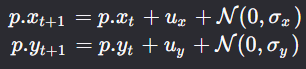

- Noise std_x dan std_y mengontrol ketidakpastian gerakan.

c. Langkah Update Bobot:
- Untuk setiap partikel, hitung jarak dan bearing ke landmark:

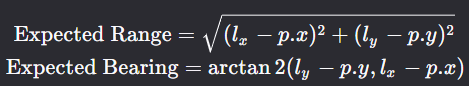

- Normalisasi bearing ke rentang [−π,π].
- Hitung likelihood menggunakan distribusi Gaussian:

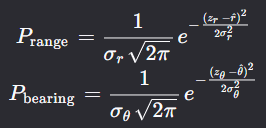

- Bobot partikel diperbarui sebagai produk dari likelihood range dan bearing.
- Normalisasi bobot agar jumlah totalnya 1.

d. Resampling Sistematis:
- Partikel dengan bobot tinggi akan direproduksi lebih banyak.
- Algoritma:
    1. Buat daftar kumulatif bobot.
    2. Bagi kumulatif menjadi interval dengan ukuran tetap (step).
    3. Pilih partikel baru berdasarkan pointer acak dalam interval.
    4. Partikel baru mendapatkan bobot seragam (1/num_particles).

e. Estimasi Lokasi Robot:
- Menghitung rata-rata tertimbang posisi partikel berdasarkan bobot:

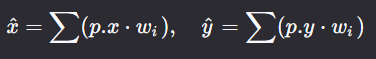



## 4. AMCL Visualizer

In [4]:
class AMCLVisualizer:
    def __init__(self, amcl, landmarks, true_pose):
        self.fig, self.ax = plt.subplots(figsize=(10, 10))
        self.amcl = amcl
        self.landmarks = landmarks
        self.true_pose = true_pose
        self.setup_plot()
        
    def setup_plot(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        self.ax.set_title("AMCL Localization (x, y only)")
        self.ax.set_xlabel("X position")
        self.ax.set_ylabel("Y position")
        
        for lid, pos in self.landmarks.items():
            self.ax.scatter(pos[0], pos[1], s=100, marker='*', color='orange', label='Landmarks' if lid == 0 else "")
        
        self.particle_plot = self.ax.scatter([], [], s=5, alpha=0.5, color='blue', label='Particles')
        self.true_pose_plot = self.ax.scatter([], [], s=100, color='red', marker='x', label='True Pose')
        self.estimated_pose_plot = self.ax.scatter([], [], s=100, color='green', marker='x', label='Estimated Pose')
        self.ax.legend()
        
    def update_plot(self):
        particles = self.amcl.particles
        x = [p.x for p in particles]
        y = [p.y for p in particles]
        self.particle_plot.set_offsets(np.c_[x, y])
        
        tx, ty, _ = self.true_pose
        self.true_pose_plot.set_offsets(np.array([[tx, ty]]))
        
        ex, ey = self.amcl.get_estimated_pose()
        self.estimated_pose_plot.set_offsets(np.array([[ex, ey]]))
        
        plt.draw()
        plt.pause(0.1)

- Visualisasi menampilkan partikel, posisi sebenarnya (merah), dan posisi estimasi (hijau).
- Landmark ditandai dengan bintang oranye.

## 5. Simulation

In [5]:
def simulate_robot_movement(true_pose, control_input):
    noise = np.random.normal(0, [0.05, 0.05])
    new_x = true_pose[0] + control_input[0] + noise[0]
    new_y = true_pose[1] + control_input[1] + noise[1]
    dx = control_input[0]
    dy = control_input[1]
    new_theta = np.arctan2(dy, dx)
    return (new_x, new_y, new_theta)

def generate_measurements(true_pose, landmarks, range_std=0.1, bearing_std=0.05):
    measurements = []
    for landmark_id, (lx, ly) in landmarks.items():
        dx = lx - true_pose[0]
        dy = ly - true_pose[1]
        distance = np.hypot(dx, dy)
        bearing = np.arctan2(dy, dx)
        bearing = (bearing + np.pi) % (2 * np.pi) - np.pi
        measurements.append((
            landmark_id,
            distance + np.random.normal(0, range_std),
            bearing + np.random.normal(0, bearing_std)
        ))
    return measurements

def robot_sin_movement():
    x = np.arange(-10, 11, 0.25)
    y = 7 * np.sin(x)
    initial_pose = [x[0], y[0], 0]
    dx = np.gradient(x)
    dy = np.gradient(y)
    movement_control = np.column_stack((dx, dy))
    return initial_pose, movement_control

- simulate_robot_movement: Memindahkan robot dengan noise pada input kontrol.
- generate_measurements: Menghasilkan pengukuran jarak dan bearing ke landmark dengan noise.
- robot_sin_movement: Menghasilkan jalur sinusoidal untuk simulasi.

## 6. Main Code

- Loop Utama:
    1. Inisialisasi 25 landmark dalam grid.
    2. Jalankan simulasi pergerakan robot sepanjang jalur sinusoidal.
    3. Setiap iterasi:
        - Perbarui posisi robot dengan noise.
        - Hasilkan pengukuran ke landmark.
        - Jalankan langkah AMCL: prediksi → update bobot → resample.
        - Perbarui visualisasi.
- Hasil: Plot menunjukkan partikel (biru), posisi sebenarnya (merah), dan estimasi (hijau).

In [ ]:
%%writefile FukuroAMCL.py

# Full .py script

import numpy as np
import math
import matplotlib.pyplot as plt

# Define the Particle for AMCL without theta
class Particle:
    def __init__(self, x, y, weight):
        self.x = x
        self.y = y
        self.weight = weight

class AMCL:
    def __init__(self, num_particles, map_landmarks, initial_pose=None):
        self.num_particles = num_particles
        self.map_landmarks = map_landmarks
        self.particles = []
        
        # Initialize particles around the initial pose (x, y)
        if initial_pose:
            x, y = initial_pose
            for _ in range(num_particles):
                noise_x = np.random.normal(x, 1)
                noise_y = np.random.normal(y, 1)
                self.particles.append(Particle(noise_x, noise_y, 1.0/num_particles))

    def predict(self, u, noise):
        # Update particle positions with control input and noise (no theta)
        std_x, std_y = noise
        for p in self.particles:
            p.x += u[0] + np.random.normal(0, std_x)
            p.y += u[1] + np.random.normal(0, std_y)

    def update(self, measurements, range_std, bearing_std):
        for p in self.particles:
            p.weight = 1.0
            for (landmark_id, measured_range, measured_bearing) in measurements:
                lx, ly = self.map_landmarks[landmark_id]
                dx = lx - p.x
                dy = ly - p.y
                expected_range = np.hypot(dx, dy)
                expected_bearing = np.arctan2(dy, dx)  # No theta adjustment
                expected_bearing = (expected_bearing + np.pi) % (2 * np.pi) - np.pi
                
                # Calculate likelihood
                prob_range = (1.0 / (range_std * np.sqrt(2 * np.pi))) * \
                           np.exp(-0.5 * ((measured_range - expected_range)/range_std)**2)
                prob_bearing = (1.0 / (bearing_std * np.sqrt(2 * np.pi))) * \
                             np.exp(-0.5 * ((measured_bearing - expected_bearing)/bearing_std)**2)
                p.weight *= prob_range * prob_bearing
        
        # Normalize weights
        total_weight = sum(p.weight for p in self.particles)
        if total_weight == 0:
            for p in self.particles:
                p.weight = 1.0 / self.num_particles
        else:
            for p in self.particles:
                p.weight /= total_weight

    def resample(self):
        weights = [p.weight for p in self.particles]
        cumulative_weights = np.cumsum(weights)
        step = cumulative_weights[-1] / self.num_particles
        start = np.random.uniform(0, step)
        
        indexes = []
        for i in range(self.num_particles):
            pointer = start + i * step
            index = np.searchsorted(cumulative_weights, pointer)
            indexes.append(index % len(self.particles))
        
        new_particles = [Particle(self.particles[i].x, self.particles[i].y, 1.0/self.num_particles)
                        for i in indexes]
        self.particles = new_particles

    def get_estimated_pose(self): # output odometry
        x = sum(p.x * p.weight for p in self.particles)
        y = sum(p.y * p.weight for p in self.particles)
        return (x, y)

class AMCLVisualizer:
    def __init__(self, amcl, landmarks, true_pose):
        self.fig, self.ax = plt.subplots(figsize=(10, 10))
        self.amcl = amcl
        self.landmarks = landmarks
        self.true_pose = true_pose
        self.setup_plot()
        
    def setup_plot(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        self.ax.set_title("AMCL Localization (x, y only)")
        self.ax.set_xlabel("X position")
        self.ax.set_ylabel("Y position")
        
        # Plot landmarks
        for lid, pos in self.landmarks.items():
            self.ax.scatter(pos[0], pos[1], s=100, marker='*', color='orange', label='Landmarks' if lid == 0 else "")
        
        # Initialize plots for particles and poses
        self.particle_plot = self.ax.scatter([], [], s=5, alpha=0.5, color='blue', label='Particles')
        self.true_pose_plot = self.ax.scatter([], [], s=100, color='red', marker='x', label='True Pose')
        self.estimated_pose_plot = self.ax.scatter([], [], s=100, color='green', marker='x', label='Estimated Pose')
        self.ax.legend()
        
    def update_plot(self):
        # Update particles
        particles = self.amcl.particles
        x = [p.x for p in particles]
        y = [p.y for p in particles]
        self.particle_plot.set_offsets(np.c_[x, y])
        
        # Update true pose (ignore theta)
        tx, ty, _ = self.true_pose
        self.true_pose_plot.set_offsets(np.array([[tx, ty]]))
        
        # Update estimated pose
        ex, ey = self.amcl.get_estimated_pose()
        self.estimated_pose_plot.set_offsets(np.array([[ex, ey]]))
        
        plt.draw()
        plt.pause(0.1)

def simulate_robot_movement(true_pose, control_input):
    # Control input is (dx, dy)
    noise = np.random.normal(0, [0.05, 0.05])
    new_x = true_pose[0] + control_input[0] + noise[0]
    new_y = true_pose[1] + control_input[1] + noise[1]
    # Compute theta based on movement direction for simulation (not used by AMCL)
    dx = control_input[0]
    dy = control_input[1]
    new_theta = np.arctan2(dy, dx)
    return (new_x, new_y, new_theta)

def generate_measurements(true_pose, landmarks, range_std=0.1, bearing_std=0.05):
    measurements = []
    for landmark_id, (lx, ly) in landmarks.items():
        dx = lx - true_pose[0]
        dy = ly - true_pose[1]
        distance = np.hypot(dx, dy)
        bearing = np.arctan2(dy, dx)  # Global frame bearing
        bearing = (bearing + np.pi) % (2 * np.pi) - np.pi
        measurements.append((
            landmark_id,
            distance + np.random.normal(0, range_std),
            bearing + np.random.normal(0, bearing_std)
        ))
    return measurements

def robot_sin_movement():
    x = np.arange(-10, 11, 0.25)
    y = 7 * np.sin(x)
    initial_pose = [x[0], y[0], 0]  # Initial theta is 0 (unused by AMCL)

    dx = np.gradient(x)
    dy = np.gradient(y)
    movement_control = np.column_stack((dx, dy))  # Control is (dx, dy)
    return initial_pose, movement_control

if __name__ == "__main__":
    # landmarks = {
    #     # ntar diganti pake line detection
    #     0: (5.0, 5.0),
    #     1: (5.0, -5.0),
    #     2: (-5.0, 5.0),
    #     3: (-5.0, -5.0),
    # }

    landmarks = {
        0: (-10.0, -10.0),
        1: (-10.0, -5.0),
        2: (-10.0, 0.0),
        3: (-10.0, 5.0),
        4: (-10.0, 10.0),
        5: (-5.0, -10.0),
        6: (-5.0, -5.0),
        7: (-5.0, 0.0),
        8: (-5.0, 5.0),
        9: (-5.0, 10.0),
        10: (0.0, -10.0),
        11: (0.0, -5.0),
        12: (0.0, 0.0),
        13: (0.0, 5.0),
        14: (0.0, 10.0),
        15: (5.0, -10.0),
        16: (5.0, -5.0),
        17: (5.0, 0.0),
        18: (5.0, 5.0),
        19: (5.0, 10.0),
        20: (10.0, -10.0),
        21: (10.0, -5.0),
        22: (10.0, 0.0),
        23: (10.0, 5.0),
        24: (10.0, 10.0),
    }

    robot_pose, movement_control = robot_sin_movement()
    amcl = AMCL(1000, landmarks, initial_pose=(robot_pose[0], robot_pose[1]))
    vis = AMCLVisualizer(amcl, landmarks, robot_pose)

    for i, u in enumerate(movement_control):
        robot_pose = simulate_robot_movement(robot_pose, u)
        measurements = generate_measurements(robot_pose, landmarks)
        
        amcl.predict(u, (0.1, 0.1))
        amcl.update(measurements, 0.1, 0.05)
        amcl.resample()
        
        vis.true_pose = robot_pose
        vis.update_plot()

    plt.show()
    plt.show()

Writing FukuroAMCL.py
